In [74]:
import torchaudio
torchaudio.set_audio_backend("soundfile")
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch
print(torch.__version__)
from torch import nn
from tqdm import tqdm
from torch.optim import Adam,SGD,RMSprop
import matplotlib.pyplot as plt
import os
import warnings
import gc
from copy import deepcopy
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import librosa
import numpy as np
import noisereduce as nr
import malaya_speech
from malaya_speech import Pipeline
import IPython.display as ipd
warnings.filterwarnings("ignore")
from pysptk.sptk import rapt
from efficientnet_pytorch import EfficientNet
import gc

1.8.0+cu111


In [75]:
seed = 529 #沛茵生日

# path

In [76]:
X_train_dir = 'train/train/'
X_test_dir = 'public_test/public_test/'
Y_train_path = 'train/meta_train.csv'

# load data

In [77]:
def preprocessing_X(wav_dir):
    files = os.listdir(wav_dir)
    files.sort() #正確排序很重要!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    X = torch.FloatTensor([])
    for f in tqdm(files[:]):
        try:
            samples, sample_rate = malaya_speech.load(X_train_dir+f)
            melspectrogram = wav2featuresflow(samples,sr=sample_rate)
            melspectrogram = melspectrogram.reshape(-1,80,157).copy()
            melspectrogram = torch.from_numpy(melspectrogram)
            X = torch.cat([X,torch.unsqueeze(melspectrogram,0)],dim=0)
            gc.collect()
        except:
            print(f)
    print('X shape:',X.shape)
    return X

def preprocessing_Y(file_path):
    Y = pd.read_csv(file_path).iloc[:,:]
    Y = Y[Y.Filename != 'train_01046']
    enc = OneHotEncoder().fit(Y[['Label']])
    Y_one_hot = enc.transform(Y[['Label']]).toarray()
    Y_one_hot = torch.FloatTensor(Y_one_hot)
    print('Y_ont_hot shape',Y_one_hot.shape)
    print('Y_df shape',Y.shape)
    return Y_one_hot,Y

In [78]:
X_train_all = torch.load('X_train_吳啟聖教的方法.pt')
X_test_all = torch.load('X_test_吳啟聖教的方法.pt')
gc.collect()

46

In [79]:
Y_train_all,Y_train_df = preprocessing_Y(Y_train_path)
print(Y_train_all.shape)
map_dict = {}
for l in Y_train_df.Label.unique():
    map_dict[l] = Y_train_df[Y_train_df.Label==l].sample(1)['Remark'].values[0]
map_dict

Y_ont_hot shape torch.Size([1199, 6])
Y_df shape (1199, 3)
torch.Size([1199, 6])


{0: 'Barking',
 1: 'Howling',
 2: 'Crying',
 3: 'COSmoke',
 4: 'GlassBreaking',
 5: 'Dishes'}

In [80]:
Y_test_all = pd.read_csv('vote_V6_排行榜0.975345284.csv') #拿目前分數最高的
Y_test_all.head(5)

,Filename,Barking,Howling,Crying,COSmoke,GlassBreaking,Other
0,public_00001,0.020279,0.036152,0.108969,0.003787,0.342543,0.488269
1,public_00002,0.076431,0.008451,0.076741,0.023729,0.002206,0.812443
2,public_00003,0.777331,0.002195,0.003087,0.121380,0.091242,0.004764
3,public_00004,0.046524,0.004801,0.077419,0.049906,0.109408,0.711941
4,public_00005,0.558227,0.007525,0.426386,0.001161,0.001056,0.005645


In [81]:
values = Y_test_all.iloc[:,1:].values.argmax(axis=1) #轉換成one hot格式
n_values = np.max(values) + 1
np.eye(n_values)[values][:5]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.]])

In [83]:
Y_test_all.iloc[:,1:] = np.eye(n_values)[values] #轉換成df格式
Y_test_all

,Filename,Barking,Howling,Crying,COSmoke,GlassBreaking,Other
0,public_00001,0.0,0.0,0.0,0.0,0.0,1.0
1,public_00002,0.0,0.0,0.0,0.0,0.0,1.0
2,public_00003,1.0,0.0,0.0,0.0,0.0,0.0
3,public_00004,0.0,0.0,0.0,0.0,0.0,1.0
4,public_00005,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
29995,private_19996,0.0,0.0,0.0,0.0,0.0,1.0
29996,private_19997,0.0,0.0,0.0,0.0,0.0,1.0
29997,private_19998,0.0,0.0,0.0,0.0,0.0,1.0
29998,private_19999,0.0,0.0,0.0,0.0,0.0,1.0


# help functions

In [84]:
def norm_mel(y, sr):
    mel = librosa.feature.melspectrogram(y, sr = sr, n_mels = 80,hop_length=512)
    mel = librosa.power_to_db(mel, ref=np.max)
    return mel.T

def plot(y, sr):
    mel = norm_mel(y, sr)
    fig, axs = plt.subplots(2, figsize=(10, 8))
    axs[0].plot(y)
    im = axs[1].imshow(np.rot90(mel), aspect='auto', interpolation='none')
    fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=axs[1])
    print('mel shape:',mel.shape)
    plt.show()

# 靜音部分消除
quantized_model = malaya_speech.vad.deep_model(model = 'vggvox-v2', quantized = True)
p = Pipeline()

pipeline_left = (
    p.map(malaya_speech.generator.frames, frame_duration_ms = 30, sample_rate = 16000)
)

pipeline_right = (
    pipeline_left.batching(5)
    .foreach_map(quantized_model.predict)
    .flatten()
)

pipeline_left.foreach_zip(pipeline_right).map(malaya_speech.combine.without_silent,
                                             threshold_to_stop = 0.05)
def remove_silent(y,sr,time_length=80000):
    y =  p(y)['without_silent']
    if len(y) > time_length:
        y = y[0:0+time_length]
    else:
        y = np.pad(y, (0,time_length-len(y)))
    return y

def wav2featuresflow(y, sr):
    y_without_silent = remove_silent(y,sr)
    melspectrogram = np.rot90(norm_mel(y, sr))
    return melspectrogram



from sklearn.metrics import confusion_matrix,accuracy_score
def plot_confusion_matrix(model,data_iter,map_dict=map_dict):
    y_true = np.array([])
    y_pred = np.array([])
    for bx,by in tqdm(data_iter):
        bx = bx.to(device)
        by = by.to(device)
        y_hat = model(bx)
        try:
            if len(y_true) == 0:
                y_true = by.argmax(axis=1).detach().cpu().numpy()
                y_pred = y_hat.argmax(axis=1).detach().cpu().numpy()
            else:
                y_true = np.hstack((y_true,by.argmax(axis=1).detach().cpu().numpy()))
                y_pred = np.hstack((y_pred,y_hat.argmax(axis=1).detach().cpu().numpy()))
        except:
            pass
    cm = pd.DataFrame(confusion_matrix(y_pred,y_true))
    cm.columns = list(map_dict.values())
    acc = accuracy_score(y_pred,y_true)
    return cm,acc

def 找超參數(search_iteration=30,max_epochs=30):
    import optuna
    sampler = optuna.samplers.CmaEsSampler()
    study = optuna.create_study(sampler=sampler,direction='maximize')
    for i in tqdm(range(search_iteration)):
        trial = study.ask()
        lr = trial.suggest_uniform('lr',1e-5,1e-2)
        valid_size = trial.suggest_uniform('valid_size',0.1,0.5)
        batch_size = trial.suggest_int("batch_size", 16, 128)
        X_train, X_valid , y_train, y_valid = train_test_split(X_train_all, Y_train_all,
                                                               test_size = valid_size, 
                                                               random_state = 1,
                                                               stratify=Y_train_all)
        trainset = TensorDataset(torch.FloatTensor(X_train.to(torch.float32)),torch.FloatTensor(y_train))
        vaildset = TensorDataset(torch.FloatTensor(X_valid.to(torch.float32)),torch.FloatTensor(y_valid))
        train_iter = DataLoader(trainset,batch_size=batch_size,num_workers=4)
        vaild_iter = DataLoader(vaildset,batch_size=batch_size,num_workers=4)
        model = torch.hub.load('moskomule/senet.pytorch','se_resnet20',num_classes=6)
        model.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        device = 'cuda:0'
        model = model.to(device)
        model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])
        optimizer = Adam(model.parameters(),lr=lr)
        loss_fn = nn.BCEWithLogitsLoss()
        model = train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=max_epochs,log_interval=1,device=device)
        model.eval()
        cm,acc = plot_confusion_matrix(model.to(device),vaild_iter)
        study.tell(trial,acc)
        print(study.best_params,study.best_value)
    return study.best_params,study.best_value

# train valid split

In [85]:
Y_test_all

,Filename,Barking,Howling,Crying,COSmoke,GlassBreaking,Other
0,public_00001,0.0,0.0,0.0,0.0,0.0,1.0
1,public_00002,0.0,0.0,0.0,0.0,0.0,1.0
2,public_00003,1.0,0.0,0.0,0.0,0.0,0.0
3,public_00004,0.0,0.0,0.0,0.0,0.0,1.0
4,public_00005,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
29995,private_19996,0.0,0.0,0.0,0.0,0.0,1.0
29996,private_19997,0.0,0.0,0.0,0.0,0.0,1.0
29997,private_19998,0.0,0.0,0.0,0.0,0.0,1.0
29998,private_19999,0.0,0.0,0.0,0.0,0.0,1.0


In [86]:
Y_test_all = torch.FloatTensor(Y_test_all.iloc[:10000,1:].values) #轉換成tensor格式
Y_test_all,Y_test_all.shape

(tensor([[0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.]]), torch.Size([10000, 6]))

In [87]:
from sklearn.model_selection import train_test_split

# 訓練驗證切分
a = X_test_all
b = Y_test_all

X_valid = X_train_all
y_valid = Y_train_all

X_train = a
y_train = b

print(X_train.shape)
print(X_valid.shape)
print(pd.DataFrame(y_train.argmax(axis=1)).value_counts())
print(pd.DataFrame(y_valid.argmax(axis=1)).value_counts())

torch.Size([10000, 1, 80, 157])
torch.Size([1199, 1, 80, 157])
5    3556
2    2152
1    1716
0    1264
3     869
4     443
dtype: int64
0    200
1    200
2    200
3    200
5    200
4    199
dtype: int64


#  create pytorch dataloader and save

In [88]:
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(torch.FloatTensor(X_train.to(torch.float32)),torch.FloatTensor(y_train))
vaildset = TensorDataset(torch.FloatTensor(X_valid.to(torch.float32)),torch.FloatTensor(y_valid))
train_iter = DataLoader(trainset,batch_size=32,num_workers=4)
vaild_iter = DataLoader(vaildset,batch_size=32,num_workers=4)
for bx,by in train_iter:
    print(bx.shape,bx.device) # batch,channel,freq,time
    print(by.shape,by.device) # batch,n_class
    break

torch.Size([32, 1, 80, 157]) cpu
torch.Size([32, 6]) cpu


# define model

In [89]:
import torch.hub
model = torch.hub.load('moskomule/senet.pytorch','se_resnet20',num_classes=64)
model.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model.fc = nn.Sequential(
    nn.Linear(64,64),
    nn.LeakyReLU(),
    nn.Dropout(0.5),#三個臭皮匠勝過一個諸葛亮
    nn.Linear(64,6))
print(model)
for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        print(m,'初始化')
        nn.init.xavier_uniform_(m.weight)
# forward test
y_hat = model(bx)
print(bx.shape,y_hat.shape)
y_hat.shape

Using cache found in /root/.cache/torch/hub/moskomule_senet.pytorch_master


CifarSEResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): CifarSEBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=16, out_features=1, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=1, out_features=16, bias=False)
          (3): Sigmoid()
        )
      )
    )
    (1)

torch.Size([32, 1, 80, 157]) torch.Size([32, 6])


torch.Size([32, 6])

# def train loop

In [90]:
from sklearn.metrics import accuracy_score

def train_step(model,train_iter,loss_fn,optimizer,device):
        model.train()
        total_loss = 0
        total_auc = 0
        for t,(x,y) in enumerate(train_iter):
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            total_auc += calculate_auc_score(model,x,y)
            loss = loss_fn(y_hat,y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        return total_loss/(t+1) ,total_auc/(t+1)

def valid_step(model,vaild_iter,loss_fn,optimizer,device):
    model.eval()
    total_loss = 0
    total_auc = 0
    for t,(x,y) in enumerate(vaild_iter):
        x,y = x.to(device),y.to(device)
        y_hat = model(x)
        total_auc += calculate_auc_score(model,x,y)
        loss = loss_fn(y_hat,y)
        total_loss += loss.item()
    return total_loss/(t+1) ,total_auc/(t+1)

def softmax2onehot(probs):
  probs = torch.FloatTensor(probs)
  max_idx = torch.argmax(probs, 1, keepdim=True)
  one_hot = torch.FloatTensor(probs.shape)
  one_hot.zero_()
  one_hot.scatter_(1, max_idx, 1)
  return one_hot.detach().cpu().numpy().astype(int)

# calculate roc_auc_score
def calculate_auc_score(model,x,y):
    y_hat = model(x).argmax(dim=1).detach().cpu().numpy()
    y = y.argmax(dim=1).detach().cpu().numpy()
    return accuracy_score(y,y_hat)


# train_loop
def train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=300,log_interval=10,device=None):
        history = {
            'train_loss':[],
            'valid_loss':[],
            'train_auc':[],
            'valid_auc':[],
            }
        current_auc = -np.inf
        best_model = None
        for i in tqdm(range(max_epochs)):
            # step
            train_loss,train_auc = train_step(model,train_iter,loss_fn,optimizer,device)
            valid_loss,valid_auc = valid_step(model,vaild_iter,loss_fn,optimizer,device)
            # record history
            history['train_loss'].append(train_loss)
            history['valid_loss'].append(valid_loss)
            history['train_auc'].append(train_auc)
            history['valid_auc'].append(valid_auc)
            # print info
            if i % log_interval == 0:
                print("epoch:{} train_loss:{:.4f} valid_loss:{:.4f} train_auc:{:.4f} valid_auc:{:.4f}".format(
                    i,history['train_loss'][-1],history['valid_loss'][-1],history['train_auc'][-1],history['valid_auc'][-1])
                    )
            # record the best model
            if history['valid_auc'][-1] >= current_auc:
                best_model = deepcopy(model.eval())
                current_auc = history['valid_auc'][-1]
                print('有進步')
            gc.collect()
        # copy best model
        model = deepcopy(best_model.eval())
        
        # plot
        plt.plot(history['train_loss'],label='train_loss')
        plt.plot(history['valid_loss'],label='valid_loss')
        plt.legend()
        plt.savefig('loss.jpg')
        plt.show()
        
        
        plt.plot(history['train_auc'],label='train_auc')
        plt.plot(history['valid_auc'],label='valid_auc')
        plt.legend()
        plt.savefig('auc.jpg')
        plt.show()
        
        
        return model

In [91]:
device = 'cuda:0'
model = model.to(device)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])

In [92]:
loss_fn = nn.BCEWithLogitsLoss()

 10%|█         | 1/10 [00:34<05:13, 34.88s/it]

epoch:0 train_loss:0.3402 valid_loss:0.3927 train_auc:0.5377 valid_auc:0.4400
有進步


 20%|██        | 2/10 [01:10<04:41, 35.14s/it]

epoch:1 train_loss:0.2712 valid_loss:0.3350 train_auc:0.6505 valid_auc:0.5400
有進步


 30%|███       | 3/10 [01:47<04:11, 35.92s/it]

epoch:2 train_loss:0.2312 valid_loss:0.2268 train_auc:0.7159 valid_auc:0.6534
有進步


 40%|████      | 4/10 [02:22<03:34, 35.76s/it]

epoch:3 train_loss:0.2092 valid_loss:0.2061 train_auc:0.7488 valid_auc:0.7191
有進步


 50%|█████     | 5/10 [02:58<02:58, 35.67s/it]

epoch:4 train_loss:0.1879 valid_loss:0.1770 train_auc:0.7764 valid_auc:0.8032
有進步


 60%|██████    | 6/10 [03:33<02:21, 35.48s/it]

epoch:5 train_loss:0.1755 valid_loss:0.1677 train_auc:0.7934 valid_auc:0.8009


 70%|███████   | 7/10 [04:10<01:47, 35.96s/it]

epoch:6 train_loss:0.1637 valid_loss:0.1269 train_auc:0.8082 valid_auc:0.8627
有進步


 80%|████████  | 8/10 [04:45<01:11, 35.81s/it]

epoch:7 train_loss:0.1545 valid_loss:0.1202 train_auc:0.8227 valid_auc:0.8544


 90%|█████████ | 9/10 [05:20<00:35, 35.60s/it]

epoch:8 train_loss:0.1484 valid_loss:0.1339 train_auc:0.8315 valid_auc:0.8599


100%|██████████| 10/10 [05:57<00:00, 35.74s/it]

epoch:9 train_loss:0.1417 valid_loss:0.1138 train_auc:0.8341 valid_auc:0.8692
有進步


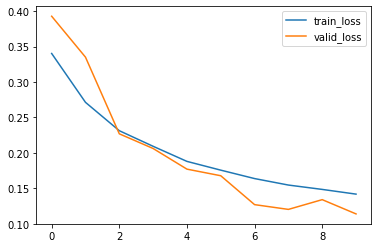

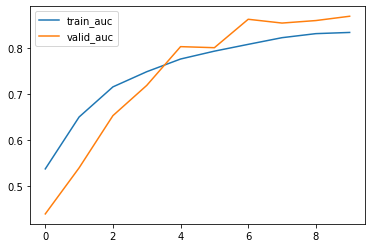

In [93]:
optimizer = Adam(model.parameters(),lr=1e-2)
model = train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=10,log_interval=1,device=device)

 10%|█         | 1/10 [00:35<05:18, 35.37s/it]

epoch:0 train_loss:0.1116 valid_loss:0.0988 train_auc:0.8712 valid_auc:0.9013
有進步


 20%|██        | 2/10 [01:10<04:43, 35.44s/it]

epoch:1 train_loss:0.0991 valid_loss:0.1092 train_auc:0.8865 valid_auc:0.8956


 30%|███       | 3/10 [01:47<04:10, 35.79s/it]

epoch:2 train_loss:0.0970 valid_loss:0.1114 train_auc:0.8926 valid_auc:0.9021
有進步


 40%|████      | 4/10 [02:22<03:34, 35.79s/it]

epoch:3 train_loss:0.0925 valid_loss:0.1075 train_auc:0.8992 valid_auc:0.9029
有進步


 50%|█████     | 5/10 [02:58<02:57, 35.59s/it]

epoch:4 train_loss:0.0897 valid_loss:0.1149 train_auc:0.9045 valid_auc:0.8931


 60%|██████    | 6/10 [03:33<02:21, 35.37s/it]

epoch:5 train_loss:0.0836 valid_loss:0.1127 train_auc:0.9096 valid_auc:0.9013


 70%|███████   | 7/10 [04:10<01:48, 36.04s/it]

epoch:6 train_loss:0.0818 valid_loss:0.1178 train_auc:0.9104 valid_auc:0.8979


 80%|████████  | 8/10 [04:45<01:11, 35.85s/it]

epoch:7 train_loss:0.0762 valid_loss:0.1250 train_auc:0.9140 valid_auc:0.8914


 90%|█████████ | 9/10 [05:21<00:35, 35.70s/it]

epoch:8 train_loss:0.0748 valid_loss:0.1261 train_auc:0.9191 valid_auc:0.8939


100%|██████████| 10/10 [05:58<00:00, 35.82s/it]

epoch:9 train_loss:0.0718 valid_loss:0.1362 train_auc:0.9225 valid_auc:0.8938


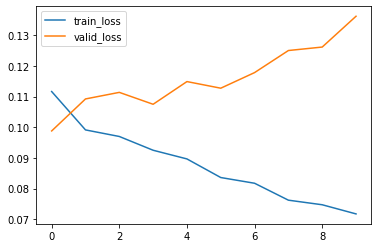

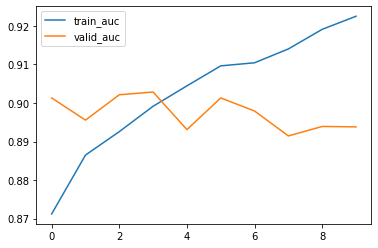

In [94]:
optimizer = Adam(model.parameters(),lr=1e-3)
model = train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=10,log_interval=1,device=device)

In [95]:
#optimizer = Adam(model.parameters(),lr=1e-4)
#model = train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=10,log_interval=1,device=device)

# model infernce test

In [96]:
model.eval()
cm,acc = plot_confusion_matrix(model.to(device),train_iter)
print(acc)
cm

100%|██████████| 313/313 [00:12<00:00, 25.92it/s]

0.9046


,Barking,Howling,Crying,COSmoke,GlassBreaking,Dishes
0,1084,73,34,1,45,86
1,21,1447,21,1,1,19
2,75,138,2047,16,0,81
3,8,22,8,837,4,20
4,12,0,0,5,322,41
5,64,36,42,9,71,3309


In [97]:
cm,acc = plot_confusion_matrix(model.to(device),vaild_iter)
print(acc)
cm

100%|██████████| 38/38 [00:02<00:00, 17.17it/s]

0.902418682235196


,Barking,Howling,Crying,COSmoke,GlassBreaking,Dishes
0,175,3,4,2,16,0
1,6,168,15,0,0,1
2,13,25,175,1,0,5
3,0,1,1,194,0,0
4,1,0,0,1,181,5
5,5,3,5,2,2,189


# submit

In [98]:
print(X_test.shape[0])

10000


In [99]:
print(X_train.shape[0])

10000


In [100]:
print(X_valid.shape[0])

1199


In [101]:
sample_submit = pd.read_csv('sample_submission.csv')
model = model.to('cuda:0')
model.eval()
batch = 100
for i in tqdm(range(0,X_test.shape[0]-batch+1,batch)):
    sample_submit.iloc[i:i+batch,1:] = model(X_test[i:i+batch].to(torch.float32).cuda()).detach().cpu().numpy()
sample_submit

100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


,Filename,Barking,Howling,Crying,COSmoke,GlassBreaking,Other
0,public_00001,-7.939251,-9.543036,-8.490507,-12.464724,-3.987186,4.325692
1,public_00002,-9.493719,-9.338923,-9.646595,-22.629076,-7.828061,10.968021
2,public_00003,3.567497,-7.542819,-7.363988,-12.509758,-6.800704,-10.443600
3,public_00004,-7.604876,-11.053317,-6.949267,-16.796406,-5.625511,6.550327
4,public_00005,-0.995990,-3.873055,0.132129,-10.236265,-11.325241,-5.721436
...,...,...,...,...,...,...,...
29995,private_19996,0.166600,0.166600,0.166600,0.166600,0.166600,0.167000
29996,private_19997,0.166600,0.166600,0.166600,0.166600,0.166600,0.167000
29997,private_19998,0.166600,0.166600,0.166600,0.166600,0.166600,0.167000
29998,private_19999,0.166600,0.166600,0.166600,0.166600,0.166600,0.167000


In [102]:
from scipy.special import softmax
a = softmax(sample_submit.iloc[:,1:].values,axis=1)
a

array([[4.71295065e-06, 9.47933111e-07, 2.71572241e-06, 5.10393455e-08,
        2.45274789e-04, 9.99746298e-01],
       [1.29890985e-09, 1.51637396e-09, 1.11477148e-09, 2.56428320e-15,
        6.87013534e-09, 9.99999989e-01],
       [9.99934819e-01, 1.49562510e-05, 1.78849739e-05, 1.04161869e-07,
        3.14137080e-05, 8.22299278e-07],
       ...,
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01],
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01],
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01]])

In [103]:
sample_submit.iloc[:,1:] = a
sample_submit

,Filename,Barking,Howling,Crying,COSmoke,GlassBreaking,Other
0,public_00001,4.712951e-06,9.479331e-07,2.715722e-06,5.103935e-08,2.452748e-04,9.997463e-01
1,public_00002,1.298910e-09,1.516374e-09,1.114771e-09,2.564283e-15,6.870135e-09,1.000000e+00
2,public_00003,9.999348e-01,1.495625e-05,1.788497e-05,1.041619e-07,3.141371e-05,8.222993e-07
3,public_00004,7.119842e-07,2.263764e-08,1.371505e-06,7.255035e-11,5.153444e-06,9.999927e-01
4,public_00005,2.406661e-01,1.354945e-02,7.436193e-01,2.335686e-05,7.861007e-06,2.133928e-03
...,...,...,...,...,...,...,...
29995,private_19996,1.666556e-01,1.666556e-01,1.666556e-01,1.666556e-01,1.666556e-01,1.667222e-01
29996,private_19997,1.666556e-01,1.666556e-01,1.666556e-01,1.666556e-01,1.666556e-01,1.667222e-01
29997,private_19998,1.666556e-01,1.666556e-01,1.666556e-01,1.666556e-01,1.666556e-01,1.667222e-01
29998,private_19999,1.666556e-01,1.666556e-01,1.666556e-01,1.666556e-01,1.666556e-01,1.667222e-01


In [104]:
sample_submit.iloc[122]

Filename         public_00123
Barking              0.026268
Howling              0.000006
Crying                0.00005
COSmoke                   0.0
GlassBreaking        0.000794
Other                0.972883
Name: 122, dtype: object

In [105]:
sample_submit.sum(axis=1)

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
29995    1.0
29996    1.0
29997    1.0
29998    1.0
29999    1.0
Length: 30000, dtype: float64

In [106]:
acc

0.902418682235196

In [107]:
# save
sample_submit.to_csv(f'senet20_20210605_random_state{seed}_validacc_{acc}_用訓練資料1199當驗證集.csv',index=False)
torch.save(model.state_dict(),f'senet20_20210605_random_state{seed}_validacc_{acc}用訓練資料1199當驗證集.pt')
#print('done')